
🌍 Global Development Indicators - Exploratory Data Analysis


This notebook performs comprehensive exploratory data analysis (EDA) on a dataset that captures socio-economic, health, environmental,
and governance indicators across countries and years.

The dataset includes features such as:
- Economic metrics (GDP, unemployment, inflation, FDI, etc.)
- Environmental indicators (CO₂ emissions, forest area, renewable energy)
- Health & development (life expectancy, healthcare capacity, child mortality)
- Education & technology (school enrollment, internet/mobile access)
- Governance, resilience, and human development indexes

🎯 Objectives:
- Understand trends over time (e.g., GDP, emissions, life expectancy)
- Compare development patterns across regions/income groups
- Explore relationships among health, environment, and digital growth
- Highlight pandemic period effects and resilience metrics

> **Importing Dependencies**

In [1]:
# 📦 Import required libraries
import numpy as np                        # Numerical operations
import pandas as pd                       # Data loading & manipulation
import matplotlib.pyplot as plt           # Basic plotting
import seaborn as sns                     # Statistical data visualization
import plotly.express as px               # Interactive plotting
import plotly.graph_objects as go         # Advanced interactive plots
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)

# ⚠️ Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazimulrahman","key":"e95a9727271c4b772b1591a2095a816a"}'}

In [3]:
# Create the .kaggle directory and copy the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install opendatasets --quiet
import opendatasets as od

# Download the dataset, ensure the URL is correct and you've set up your Kaggle API credentials
od.download("https://www.kaggle.com/datasets/michaelmatta0/global-development-indicators-2000-2020", force=True)

Dataset URL: https://www.kaggle.com/datasets/michaelmatta0/global-development-indicators-2000-2020


100%|██████████| 1.25M/1.25M [00:00<00:00, 463MB/s]

In [5]:
df = pd.read_csv('/content/global-development-indicators-2000-2020/Global_Development_Indicators_2000_2020.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Years covered: {df['year'].min()} to {df['year'].max()}")
print(f"Number of unique countries: {df['country_code'].nunique()}")

Dataset shape: (5556, 47)
Years covered: 2000 to 2020
Number of unique countries: 265


In [6]:
def plot_categorical_distributions(
    df,
    columns,
    sort_by='count',  # or 'alphabetical'
    show_percent=True,
    figsize=(10, 4),
    color='skyblue',
    rotation=45,
    bar_label=True
):
    """
    Plots bar charts for categorical column distributions.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame.
    columns : list of str
        List of categorical columns to plot.
    sort_by : str
        'count' to sort by frequency, 'alphabetical' to sort by category.
    show_percent : bool
        If True, shows % on bar labels.
    figsize : tuple
        Figure size (width, height).
    color : str
        Bar color.
    rotation : int
        Rotation angle for x-axis labels.
    bar_label : bool
        If True, shows count/percent on each bar.
    """

    for col in columns:
        plt.figure(figsize=figsize)

        # Handle missing values
        value_counts = df[col].fillna('Missing').value_counts(dropna=False)
        if sort_by == 'alphabetical':
            value_counts = value_counts.sort_index()

        ax = value_counts.plot(kind='bar', color=color)
        plt.title(f"Distribution of '{col}'")
        plt.xticks(rotation=rotation)
        plt.ylabel('Count')

        # Add text labels
        if bar_label:
            total = value_counts.sum()
            for i, v in enumerate(value_counts):
                percent = f" ({(v / total * 100):.1f}%)" if show_percent else ""
                ax.text(i, v + total * 0.01, f"{v}{percent}", ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

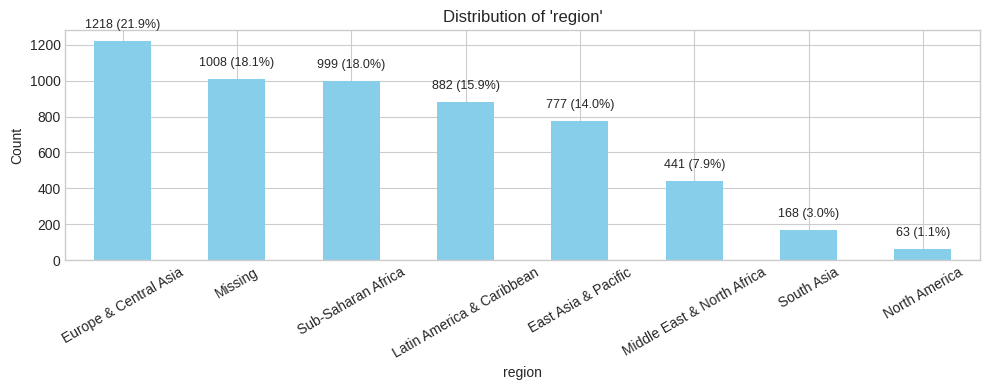

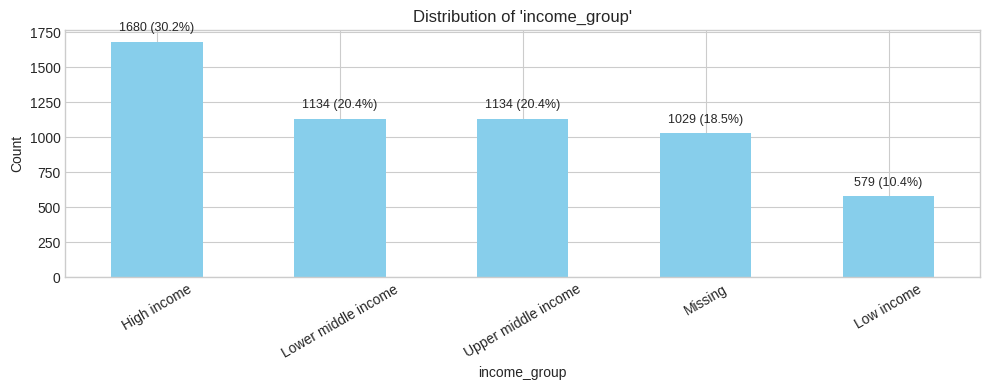

In [7]:
plot_categorical_distributions(
    df,
    columns=['region', 'income_group'],
    sort_by='count',
    show_percent=True,
    figsize=(10, 4),
    rotation=30
)

<Figure size 1400x600 with 0 Axes>

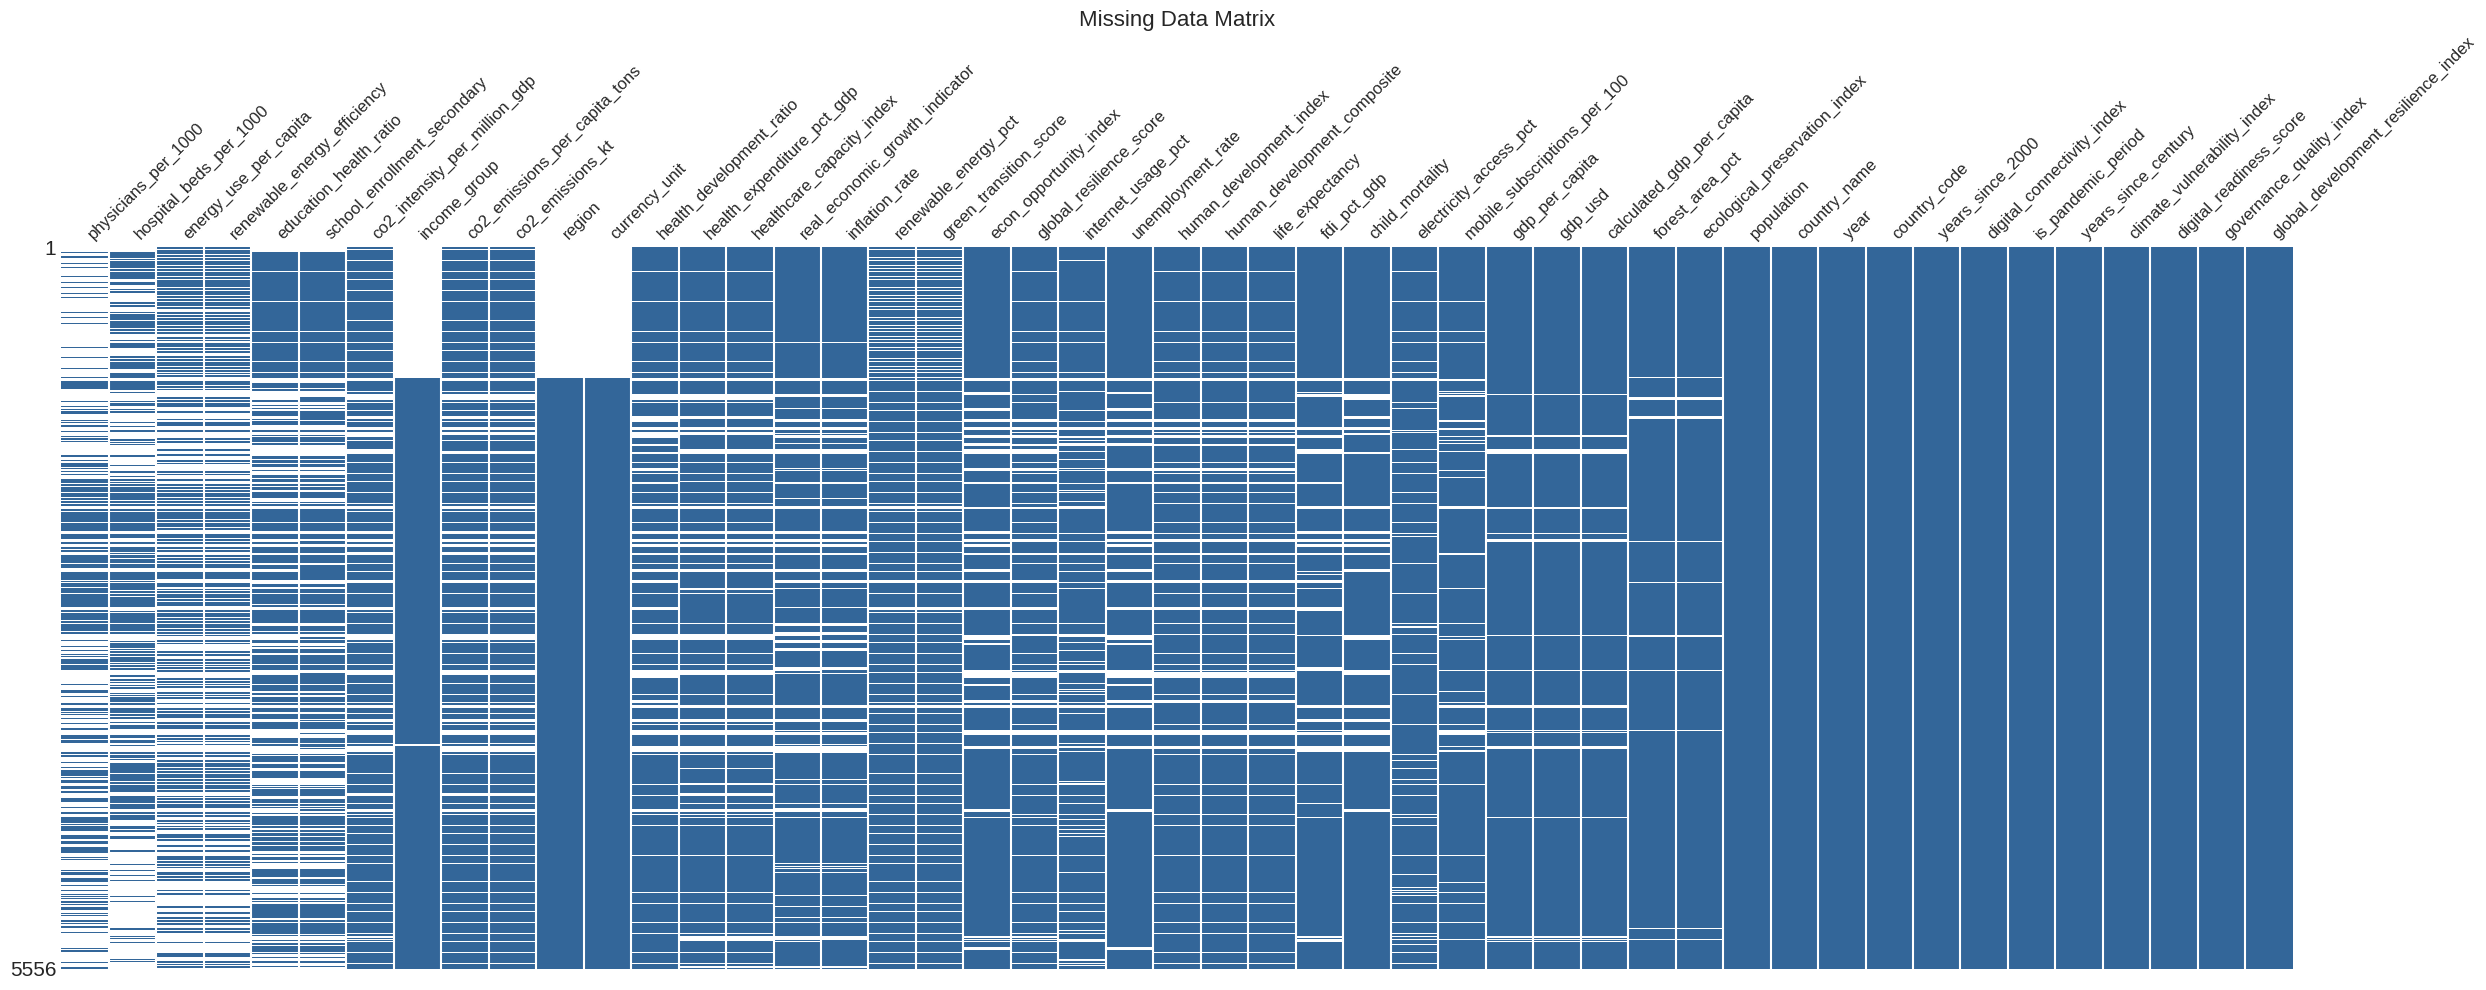

In [10]:
# Optional: Sort columns by % of missing values (helps in visual clarity)
missing_order = df.isnull().mean().sort_values(ascending=False).index
df_sorted = df[missing_order]

# Optional: For large datasets, you can sample a subset of rows
# df_sorted = df_sorted.sample(1000, random_state=42)

# Create the matrix plot
plt.figure(figsize=(14, 6))
msno.matrix(
    df_sorted,
    fontsize=12,
    color=(0.2, 0.4, 0.6),  # Custom color (bluish tone)
    sparkline=False         # Hide sparkline for cleaner look
)
plt.title("Missing Data Matrix", fontsize=16)
plt.tight_layout()
plt.show()


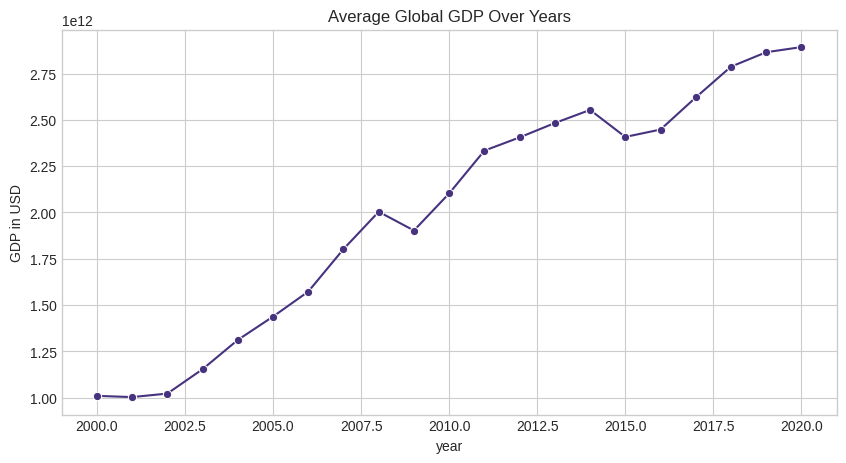

In [11]:
# --- Line Plot: Global GDP over Years ---
# This plot visualizes the trend of the average global GDP over the years.
# It will help us understand the general economic growth over time.

plt.figure(figsize=(10, 5))
# Group the data by year and calculate the mean GDP for each year
df_grouped = df.groupby('year')['gdp_usd'].mean().reset_index()
sns.lineplot(data=df_grouped, x='year', y='gdp_usd', marker='o')
plt.title("Average Global GDP Over Years")
plt.ylabel("GDP in USD")
plt.grid(True)  # Show grid
plt.show()

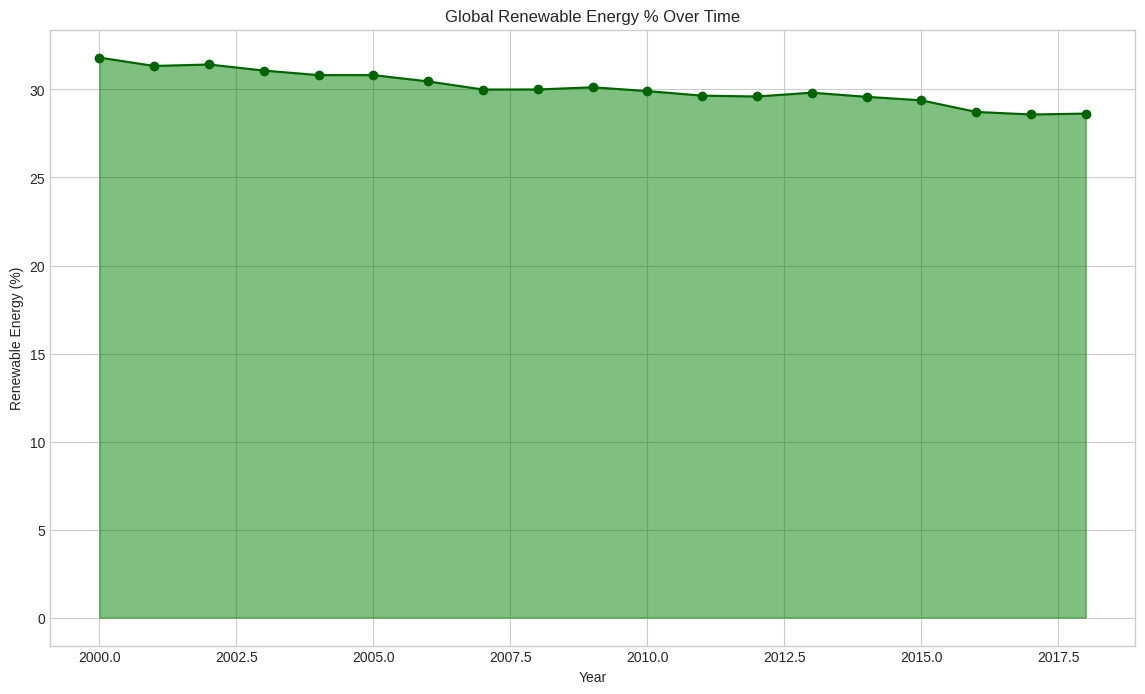

In [13]:
# --- Area Plot: Renewable Energy Over Time ---
# This plot visualizes the percentage of renewable energy usage over time.
# It helps us track progress toward sustainability goals.

df_renew = df.groupby('year')['renewable_energy_pct'].mean().reset_index()
# Create an area plot to show the renewable energy trend, with a line on top for clarity
plt.fill_between(df_renew['year'], df_renew['renewable_energy_pct'], color='green', alpha=0.5)  # Area plot
plt.plot(df_renew['year'], df_renew['renewable_energy_pct'], marker='o', color='darkgreen')  # Line plot
plt.title("Global Renewable Energy % Over Time")
plt.ylabel("Renewable Energy (%)")
plt.xlabel("Year")
plt.grid(True)  # Show grid
plt.show()

In [14]:
# --- Plotly Interactive: Country GDP Trend ---
# This interactive plot shows GDP trends for the top 5 countries with the highest number of data points.
# It helps us see how different countries' GDPs have evolved over time, especially the major players in the global economy.

top_countries = df['country_name'].value_counts().nlargest(5).index  # Get the top 5 countries by number of records
filtered_df = df[df['country_name'].isin(top_countries)]  # Filter dataset for the top countries

# Use Plotly to create an interactive line plot where each country has its own line
fig = px.line(filtered_df, x="year", y="gdp_usd", color="country_name",
              title="GDP Trend Over Years (Top 5 Countries)")
fig.show(renderer="notebook")

In [17]:
class DataFrameCleaner:
    def __init__(self,
                 missing_threshold=30,       # % threshold to consider a column as "too missing"
                 impute_strategy='mean',     # Strategy for filling in missing numeric values
                 normalize_strategy='zscore',# How to scale numeric features: 'zscore' or 'minmax'
                 remove_outliers=True,       # Whether to remove outliers
                 verbose=False):             # Whether to print detailed logs
        self.missing_threshold = missing_threshold
        self.impute_strategy = impute_strategy
        self.normalize_strategy = normalize_strategy
        self.remove_outliers = remove_outliers
        self.verbose = verbose
        self.summary_ = {}  # Dictionary to track what changes were made

    def clean(self, df):
        df = df.copy()  # Work on a copy to avoid altering the original DataFrame
        self.summary_ = {
            'dropped_columns': [],
            'imputed_columns': [],
            'scaled_percentage_columns': [],
            'financial_scaling': [],
            'normalized_columns': [],
            'outliers_removed': 0
        }

        # ---- 1. Detect and optionally report high-missing columns ----
        missing_pct = df.isnull().mean() * 100
        high_missing = missing_pct[missing_pct > self.missing_threshold]

        if self.verbose and not high_missing.empty:
            print(f"\nColumns with >{self.missing_threshold}% missing values:")
            print(high_missing)

        # Optional: drop high-missing columns
        # df.drop(columns=high_missing.index, inplace=True)
        # self.summary_['dropped_columns'] = high_missing.index.tolist()

        # ---- 2. Impute missing values ----
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype == 'object' or df[col].dtype.name == 'category':
                    # Categorical: use the most frequent value (mode)
                    value = df[col].mode().iloc[0]
                else:
                    # Numeric: use chosen imputation strategy
                    if self.impute_strategy == 'mean':
                        value = df[col].mean()
                    elif self.impute_strategy == 'median':
                        value = df[col].median()
                    elif self.impute_strategy == 'mode':
                        value = df[col].mode().iloc[0]
                df[col].fillna(value, inplace=True)
                self.summary_['imputed_columns'].append(col)

        # ---- 3. Convert percentage-like columns (e.g. 'unemployment_pct') to decimals ----
        pct_cols = [col for col in df.columns
                    if any(x in col.lower() for x in ['pct', '_rate', 'index', 'percent'])]

        for col in pct_cols:
            try:
                if df[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
                    if df[col].max() > 1 and df[col].max() <= 100 and df[col].min() >= 0:
                        df[col] = df[col] / 100
                        self.summary_['scaled_percentage_columns'].append(col)
            except:
                continue

        # ---- 4. Scale financial columns like GDP to billions ----
        scale_map = {
            'gdp_usd': 'gdp_usd_billions',
            'revenue_usd': 'revenue_usd_billions',
            'income_usd': 'income_usd_billions'
        }

        for col, new_col in scale_map.items():
            if col in df.columns:
                df[new_col] = df[col] / 1e9
                self.summary_['financial_scaling'].append((col, new_col))

        # ---- 5. Remove outliers using the IQR (Interquartile Range) method ----
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if self.remove_outliers:
            initial_rows = df.shape[0]
            for col in numeric_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower = Q1 - 1.5 * IQR
                upper = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower) & (df[col] <= upper)]
            removed = initial_rows - df.shape[0]
            self.summary_['outliers_removed'] = removed

        # ---- 6. Normalize all numeric columns ----
        if self.normalize_strategy == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        try:
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            self.summary_['normalized_columns'] = numeric_cols
        except Exception as e:
            if self.verbose:
                print(f"Normalization failed: {e}")

        # ---- 7. Print Summary ----
        if self.verbose:
            print("\nSummary of Transformations:")
            for key, value in self.summary_.items():
                print(f"- {key}: {value}")

        return df

In [18]:
# Create cleaner instance
cleaner = DataFrameCleaner(verbose=True)

# Clean the data
cleaned_df = cleaner.clean(df=df)


Columns with >30% missing values:
energy_use_per_capita          47.174226
school_enrollment_secondary    32.397408
hospital_beds_per_1000         51.709863
physicians_per_1000            59.125270
renewable_energy_efficiency    47.174226
education_health_ratio         34.863211
dtype: float64

Summary of Transformations:
- dropped_columns: []
- imputed_columns: ['region', 'income_group', 'currency_unit', 'gdp_usd', 'gdp_per_capita', 'inflation_rate', 'unemployment_rate', 'fdi_pct_gdp', 'co2_emissions_kt', 'energy_use_per_capita', 'renewable_energy_pct', 'forest_area_pct', 'electricity_access_pct', 'life_expectancy', 'child_mortality', 'school_enrollment_secondary', 'health_expenditure_pct_gdp', 'hospital_beds_per_1000', 'physicians_per_1000', 'internet_usage_pct', 'mobile_subscriptions_per_100', 'calculated_gdp_per_capita', 'real_economic_growth_indicator', 'econ_opportunity_index', 'co2_emissions_per_capita_tons', 'co2_intensity_per_million_gdp', 'green_transition_score', 'ecologica

In [19]:
def summarize_by_time_period(df, year_col='year'):
    """
    Adds a 'time_period' column to the DataFrame based on specified year bins,
    then computes the mean of selected development indicators grouped by time period.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame containing at least a 'year' column and development indicators.
    year_col : str
        Column name for the year variable (default is 'year').

    Returns:
    --------
    pd.DataFrame
        A summary DataFrame with mean values of selected indicators by time period.
    """

    # ---- 1. Create 'time_period' column by binning years into defined ranges ----
    df['time_period'] = pd.cut(
        df[year_col],
        bins=[1999, 2007, 2013, 2019, 2025],                  # Define edges for each period
        labels=['2000-2007', '2008-2013', '2014-2019', '2020-2025']  # Assign readable labels
    )

    # ---- 2. Display the label ----
    print("\n===== SUMMARY BY TIME PERIOD =====")

    # ---- 3. Define which columns to average in the summary ----
    indicator_cols = [
        'gdp_per_capita',
        'life_expectancy',
        'renewable_energy_pct',
        'co2_emissions_per_capita_tons',
        'internet_usage_pct',
        'school_enrollment_secondary',
        'global_development_resilience_index'
    ]

    # ---- 4. Group by the 'time_period' and calculate the mean of the selected indicators ----
    time_summary = (
        df.groupby('time_period')[indicator_cols]
          .mean()         # Average within each time group
          .round(2)       # Round for better readability
    )

    # ---- 5. Print the result ----
    print(time_summary)

    return time_summary

In [20]:
# Assuming 'df' has a 'year' column and all necessary indicators
summary_df = summarize_by_time_period(df)


===== SUMMARY BY TIME PERIOD =====
             gdp_per_capita  life_expectancy  renewable_energy_pct  \
time_period                                                          
2000-2007          10351.01            67.72                 30.97   
2008-2013          15588.78            70.26                 29.85   
2014-2019          16430.40            72.10                 29.02   
2020-2025          14354.54              NaN                   NaN   

             co2_emissions_per_capita_tons  internet_usage_pct  \
time_period                                                      
2000-2007                             4.28               16.31   
2008-2013                             4.38               34.28   
2014-2019                             4.18               52.07   
2020-2025                              NaN               80.99   

             school_enrollment_secondary  global_development_resilience_index  
time_period                                                       

In [26]:
def summarize_by_income_and_period(df,
                                    income_col='income_group',
                                    period_col='time_period',
                                    metrics=None,
                                    round_digits=2,
                                    include_counts=False,
                                    include_std=False,
                                    export_path=None,
                                    verbose=True):
    """
    Summarizes mean, count, and std of metrics by income group and time period.

    Parameters:
    -----------
    df : pd.DataFrame
        Input data.
    income_col : str
        Column for income grouping.
    period_col : str
        Column for time periods.
    metrics : list of str
        Metrics to summarize.
    round_digits : int
        Decimal rounding.
    include_counts : bool
        If True, include count of observations per group.
    include_std : bool
        If True, include standard deviation.
    export_path : str
        File path to export the summary CSV (optional).

    verbose : bool
        If True, print the summary.

    Returns:
    --------
    pd.DataFrame
        Grouped summary DataFrame.
    """

    # Use default metrics if not provided
    if metrics is None:
        metrics = [
            'gdp_per_capita',
            'life_expectancy',
            'co2_emissions_per_capita_tons',
            'internet_usage_pct',
            'global_development_resilience_index'
        ]

    # Check for required columns
    required_cols = [income_col, period_col] + metrics
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in DataFrame: {missing}")

    # Group the data
    grouped = df.groupby([income_col, period_col])

    # Calculate mean
    summary = grouped[metrics].mean().round(round_digits)

    # Optionally add count and std
    if include_counts:
        counts = grouped.size().rename("count").reset_index()
        summary = summary.reset_index().merge(counts, on=[income_col, period_col]).set_index([income_col, period_col])

    if include_std:
        stds = grouped[metrics].std().round(round_digits)
        stds.columns = [f"{col}_std" for col in stds.columns]
        summary = summary.merge(stds, left_index=True, right_index=True)

    # Export to CSV if requested
    if export_path:
        summary.to_csv(export_path)
        if verbose:
            print(f"\n📁 Summary exported to: {export_path}")

    # Print summary if requested
    if verbose:
        print("\n===== BY INCOME GROUP AND PERIOD =====")
        print(summary)

    return summary

In [27]:
summary = summarize_by_income_and_period(
    df,
    include_counts=True,
    include_std=True,
    export_path='income_time_summary.csv',
    verbose=True
)


📁 Summary exported to: income_time_summary.csv

===== BY INCOME GROUP AND PERIOD =====
                                 gdp_per_capita  life_expectancy  \
income_group        time_period                                    
High income         2000-2007          28348.23            76.84   
                    2008-2013          40707.33            78.48   
                    2014-2019          42244.26            79.60   
                    2020-2025          38601.19              NaN   
Low income          2000-2007            620.44            53.96   
                    2008-2013            937.32            58.44   
                    2014-2019            715.90            61.45   
                    2020-2025            674.54              NaN   
Lower middle income 2000-2007           1176.19            62.98   
                    2008-2013           2254.22            65.93   
                    2014-2019           2528.59            68.25   
                    2020-202

In [28]:
def analyze_relationship(
    df,
    x,
    y,
    title=None,
    hue=None,
    log_x=False,
    log_y=False,
    recent_only=False,
    corr_method='pearson',
    save_path=None,
    figsize=(10, 6),
    alpha=0.6,
    point_size=80,
    line_color='red',
    xlabel=None,
    ylabel=None,
    show_corr=True
):
    """
    Visualizes and computes the relationship between two variables using a scatter plot with regression line.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame.
    x, y : str
        Column names for X and Y axes.
    title : str
        Title of the plot.
    hue : str, optional
        Column for color grouping.
    log_x, log_y : bool
        Use log scale for X or Y axis.
    recent_only : bool
        Filter to only include data from 2015 onwards.
    corr_method : str
        Method for correlation ('pearson', 'spearman', 'kendall').
    save_path : str, optional
        Path to save the plot image.
    figsize : tuple
        Size of the plot.
    alpha : float
        Transparency for scatter points.
    point_size : int
        Size of scatter points.
    line_color : str
        Color of the regression line.
    xlabel, ylabel : str, optional
        Axis labels. If None, uses column names.
    show_corr : bool
        Whether to display correlation in the title.

    Returns:
    --------
    float or None
        Correlation coefficient, or None if data is insufficient.
    """

    # Subset recent data if specified
    data = df[df['year'] >= 2015] if recent_only else df

    # Prepare data with selected columns
    cols = [x, y] + ([hue] if hue else [])
    data = data[cols].dropna()

    if data.empty:
        print(f"⚠️ Skipping plot: {title or f'{x} vs {y}'} (no data)")
        return None

    # Compute correlation
    corr = data[x].corr(data[y], method=corr_method)
    if title is None:
        title = f"{x} vs {y}"

    print(f"{title} — Correlation ({corr_method}): {corr:.3f}")

    # Plot with regression line
    g = sns.lmplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        height=figsize[1],
        aspect=figsize[0] / figsize[1],
        scatter_kws={'alpha': alpha, 's': point_size},
        line_kws={'color': line_color}
    )

    # Set log scale if needed
    if log_x:
        g.set(xscale='log')
    if log_y:
        g.set(yscale='log')

    # Set axis labels and title
    g.set_axis_labels(xlabel or x, ylabel or y)
    if show_corr:
        plt.title(f"{title}\nCorrelation ({corr_method}): {corr:.3f}", fontsize=16)
    else:
        plt.title(title, fontsize=16)

    plt.tight_layout()

    # Save plot if path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"✅ Plot saved to: {save_path}")

    plt.show()
    return corr

GDP vs Life Expectancy — Correlation (spearman): 0.870
✅ Plot saved to: gdp_lifeexp_plot.png


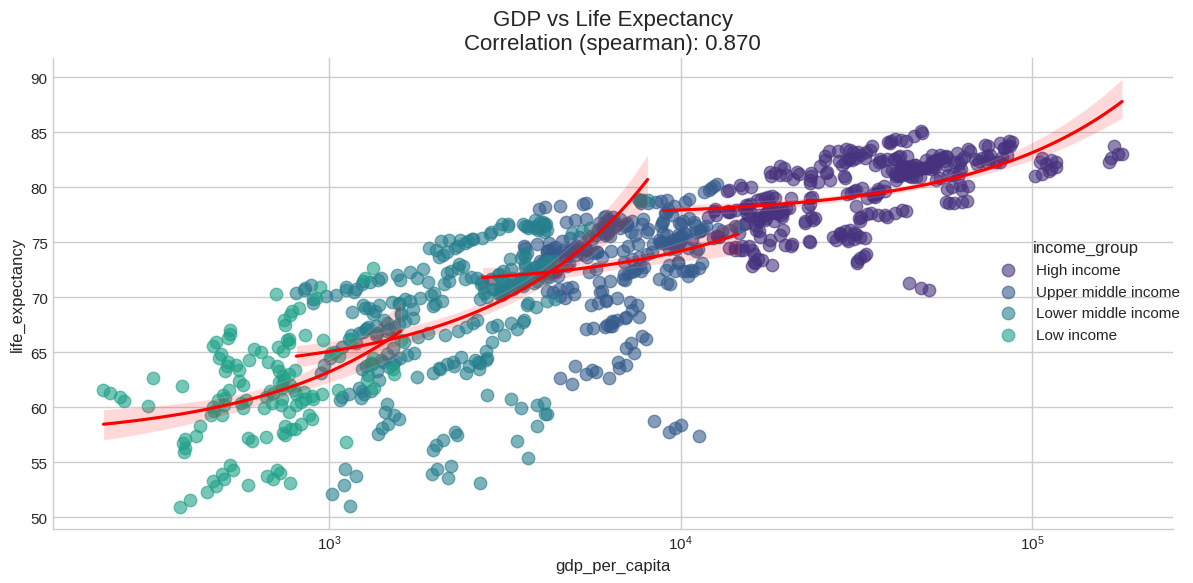

In [29]:
corr_value = analyze_relationship(
    df,
    x='gdp_per_capita',
    y='life_expectancy',
    title='GDP vs Life Expectancy',
    hue='income_group',
    log_x=True,
    recent_only=True,
    corr_method='spearman',
    save_path='gdp_lifeexp_plot.png'
)